--- FINAL RESULTS TABLE ---
                Model   RMSFE                   Type
0   ARIMA (Benchmark)  0.5442    Linear / Univariate
2  VAR (Multivariate)  0.5462  Linear / Multivariate
1  Random Forest (ML)  0.6503        Non-Linear / ML

Table saved as 'final_model_comparison.csv'


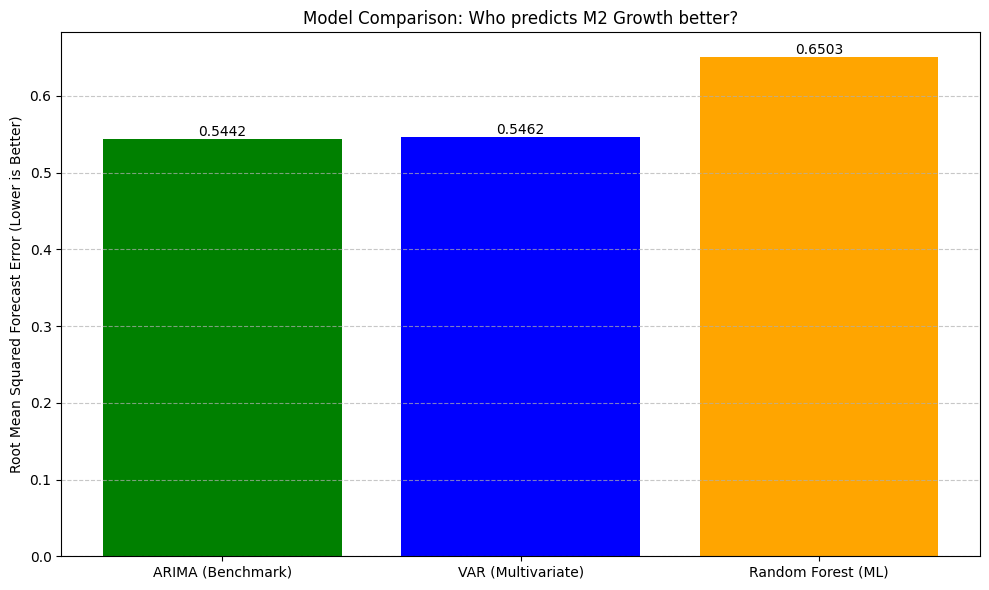

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

rmsfe_arima = 0.5442  
rmsfe_rf    = 0.6503  
rmsfe_var   = 0.5462  

# creation on dataframe
results_df = pd.DataFrame({
    'Model': ['ARIMA (Benchmark)', 'Random Forest (ML)', 'VAR (Multivariate)'],
    'RMSFE': [rmsfe_arima, rmsfe_rf, rmsfe_var],
    'Type': ['Linear / Univariate', 'Non-Linear / ML', 'Linear / Multivariate']
})

# ordering the results
results_df = results_df.sort_values(by='RMSFE', ascending=True)

print("--- FINAL RESULTS TABLE ---")
print(results_df)

# export csv
results_df.to_csv('final_model_comparison.csv', index=False)
print("\nTable saved as 'final_model_comparison.csv'")

# final graph
plt.figure(figsize=(10, 6))
bars = plt.bar(results_df['Model'], results_df['RMSFE'], color=['green', 'blue', 'orange'])
plt.ylabel('Root Mean Squared Forecast Error (Lower is Better)')
plt.title('Model Comparison: Who predicts M2 Growth better?')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('final_comparison_chart.png')
plt.show()

--- FINAL RESULTS TABLE ---
           Model                   Type   RMSFE
0          ARIMA    Univariate (Linear)  0.5442
1            VAR  Multivariate (Linear)  0.5462
2  Random Forest        ML (Non-Linear)  0.6503


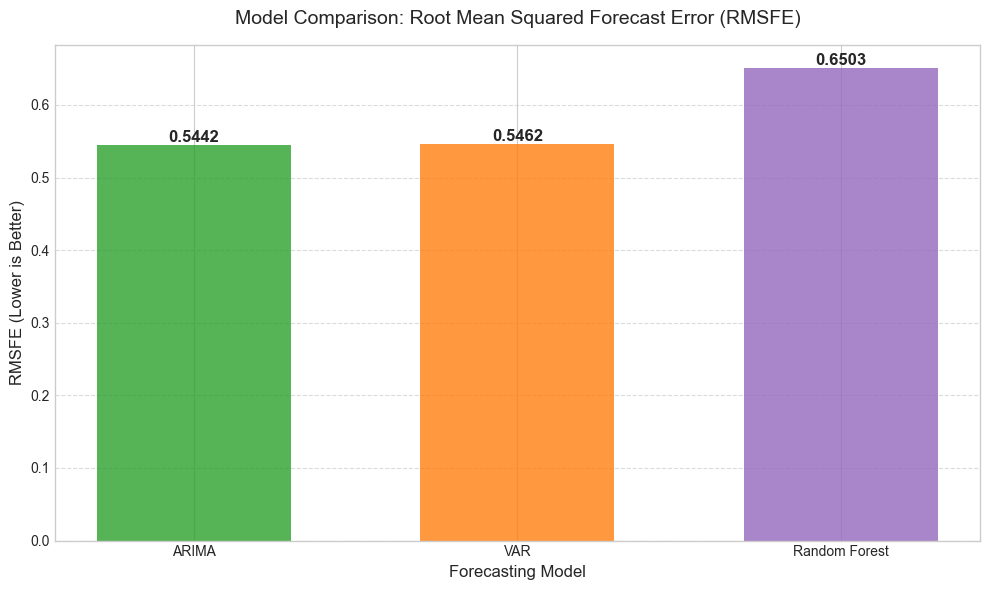


Chart saved as 'model_comparison_chart.png'.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for professional plotting
plt.style.use('seaborn-v0_8-whitegrid')

# --- 1. Input Real Results ---
# These are the RMSFE values obtained from the previous notebooks
rmsfe_arima = 0.5442
rmsfe_var   = 0.5462
rmsfe_rf    = 0.6503

# --- 2. Create Comparison DataFrame ---
results_df = pd.DataFrame({
    'Model': ['ARIMA', 'VAR', 'Random Forest'],
    'RMSFE': [rmsfe_arima, rmsfe_var, rmsfe_rf],
    'Type': ['Univariate (Linear)', 'Multivariate (Linear)', 'ML (Non-Linear)'],
    'Color': ['#2ca02c', '#ff7f0e', '#9467bd'] # Green, Orange, Purple
})

# Sort by RMSFE (Lower is Better)
results_df = results_df.sort_values(by='RMSFE', ascending=True)

print("--- FINAL RESULTS TABLE ---")
print(results_df[['Model', 'Type', 'RMSFE']])

# Optional: Save table to CSV for the report
results_df[['Model', 'Type', 'RMSFE']].to_csv('final_model_comparison.csv', index=False)

# --- 3. Generate Comparison Plot ---
plt.figure(figsize=(10, 6))

# Create Bar Chart
bars = plt.bar(results_df['Model'], results_df['RMSFE'], color=results_df['Color'], alpha=0.8, width=0.6)

# Add title and labels
plt.title('Model Comparison: Root Mean Squared Forecast Error (RMSFE)', fontsize=14, pad=15)
plt.ylabel('RMSFE (Lower is Better)', fontsize=12)
plt.xlabel('Forecasting Model', fontsize=12)

# Add grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Adjust layout and save
plt.tight_layout()
plt.savefig('model_comparison_chart.png', dpi=300)
plt.show()

print("\nChart saved as 'model_comparison_chart.png'.")

Preparing data for final comparison...
Generating forecasts for all models (this takes a few seconds)...


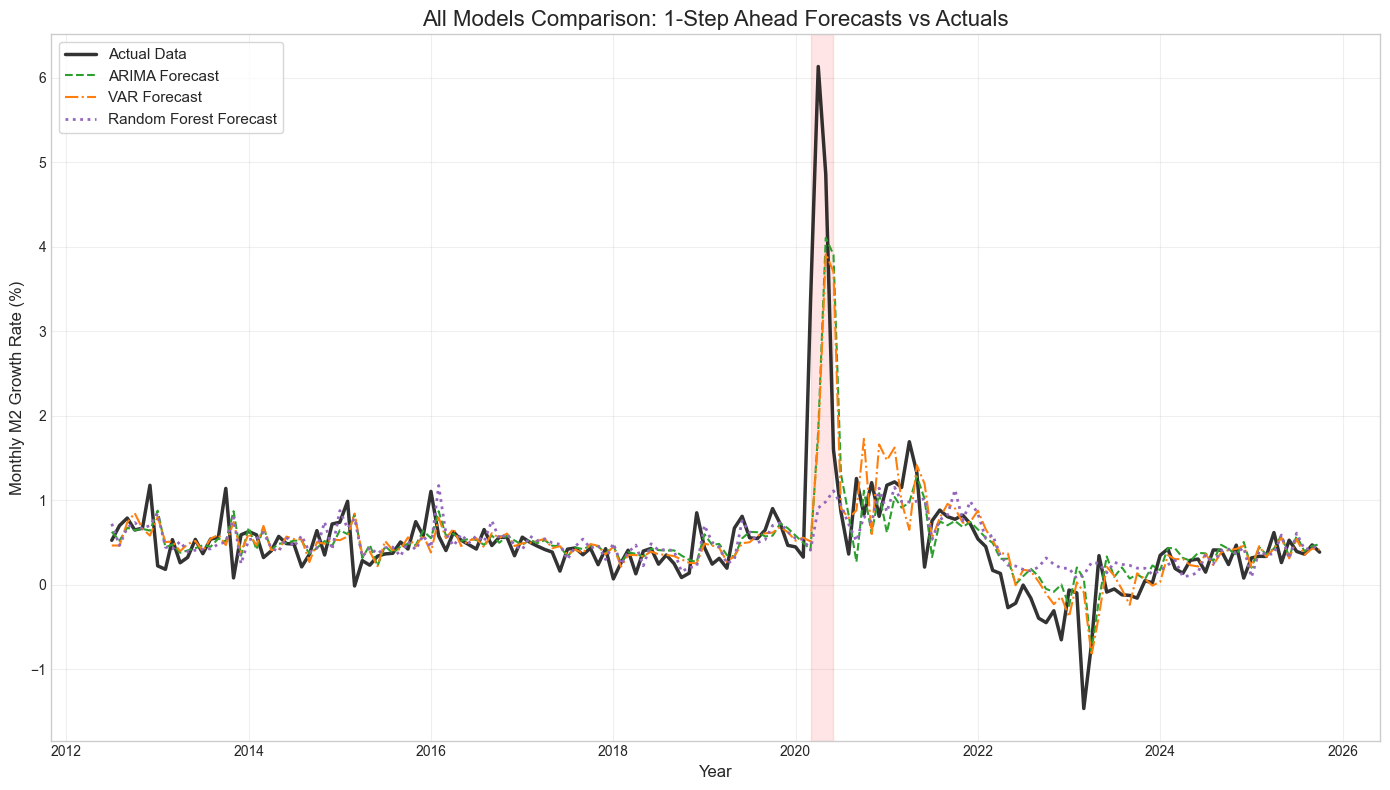

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from sklearn.ensemble import RandomForestRegressor

# --- 1. Ricaricamento e Preparazione Dati (Master) ---
print("Preparing data for final comparison...")

# Load Data
df_m2 = pd.read_csv('../data/raw/M2SL.csv', parse_dates=['observation_date'], index_col='observation_date')
df_rate = pd.read_csv('../data/raw/FEDFUNDS.csv', parse_dates=['observation_date'], index_col='observation_date')

# Merge & Transform
df_multi = pd.concat([df_m2, df_rate['FEDFUNDS']], axis=1).dropna()
df_multi.columns = ['M2', 'FEDFUNDS']
df_multi['M2_Growth'] = np.log(df_multi['M2']).diff() * 100
df_multi['Rate_Diff'] = df_multi['FEDFUNDS'].diff()
df_final = df_multi[['M2_Growth', 'Rate_Diff']].dropna()

# Split Train/Test (80/20)
n_obs = len(df_final)
n_test = int(n_obs * 0.2)
n_train = n_obs - n_test
train = df_final.iloc[:n_train]
test = df_final.iloc[n_train:]

# --- 2. Generazione Previsioni (Simulazione Rapida) ---
print("Generating forecasts for all models (this takes a few seconds)...")

# A. ARIMA Predictions (Rolling)
history_arima = train['M2_Growth'].tolist()
preds_arima = []
# Nota: Usiamo un ordine fisso (es. 4,0,1) per velocità in questo grafico riassuntivo, 
# ma idealmente caricheresti i risultati salvati.
for i in range(len(test)):
    model = ARIMA(history_arima, order=(4,0,1)) 
    model_fit = model.fit()
    preds_arima.append(model_fit.forecast()[0])
    history_arima.append(test['M2_Growth'].iloc[i])

# B. VAR Predictions (Rolling)
history_var = train.values.tolist()
preds_var = []
optimal_lag = 15
for i in range(len(test)):
    # Re-fitting VAR step-by-step
    model = VAR(pd.DataFrame(history_var, columns=['M2_Growth', 'Rate_Diff']))
    res = model.fit(optimal_lag)
    lagged_values = np.array(history_var)[-optimal_lag:]
    pred = res.forecast(y=lagged_values, steps=1)
    preds_var.append(pred[0][0])
    history_var.append(test.iloc[i].values.tolist())

# C. Random Forest Predictions
def create_lags(data, lags=12):
    df = pd.DataFrame(data)
    cols = [df.shift(i) for i in range(1, lags+1)]
    df_lags = pd.concat(cols, axis=1).dropna()
    df_lags.columns = [f'Lag_{i}' for i in range(1, lags+1)]
    df_lags['Target'] = df['Target'] if 'Target' in df else df.iloc[:,0]
    return df_lags

ml_data = create_lags(df_final['M2_Growth'], 12)
split_date = test.index[0]
train_ml = ml_data[ml_data.index < split_date]
test_ml = ml_data[ml_data.index >= split_date]

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(train_ml.drop('Target', axis=1), train_ml['Target'])
preds_rf = rf.predict(test_ml.drop('Target', axis=1))

# --- 3. Plotting Finale ---
plt.figure(figsize=(14, 8))

# Plot Actual Data (Black Line)
# Tracciamo solo i dati del Test set per chiarezza
plt.plot(test.index, test['M2_Growth'], label='Actual Data', color='black', linewidth=2.5, alpha=0.8)

# Plot ARIMA (Green)
plt.plot(test.index, preds_arima, label='ARIMA Forecast', color='#2ca02c', linestyle='--', linewidth=1.5)

# Plot VAR (Orange)
plt.plot(test.index, preds_var, label='VAR Forecast', color='#ff7f0e', linestyle='-.', linewidth=1.5)

# Plot Random Forest (Purple)
# Allineiamo le lunghezze (RF potrebbe aver perso qualche osservazione iniziale se i lag non erano allineati, qui usiamo l'indice corretto)
plt.plot(test_ml.index, preds_rf, label='Random Forest Forecast', color='#9467bd', linestyle=':', linewidth=2)

# Styling
plt.title('All Models Comparison: 1-Step Ahead Forecasts vs Actuals', fontsize=16)
plt.ylabel('Monthly M2 Growth Rate (%)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.legend(loc='upper left', fontsize=11, frameon=True)
plt.grid(True, alpha=0.3)

# Evidenziazione periodo Covid (Opzionale)
plt.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2020-06-01'), color='red', alpha=0.1, label='Covid Volatility')

plt.tight_layout()
plt.savefig('final_forecast_comparison_lines.png', dpi=300)
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np

def calculate_metrics(y_true, y_pred, model_name):
    # Converti in array numpy per sicurezza
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # 1. RMSFE (Root Mean Squared Forecast Error)
    mse = mean_squared_error(y_true, y_pred)
    rmsfe = np.sqrt(mse)
    
    # 2. MAFE (Mean Absolute Forecast Error) - Equivalente al MAE
    mafe = mean_absolute_error(y_true, y_pred)
    
    # 3. MFE (Mean Forecast Error) - Indica il Bias
    # MFE = Media(Reale - Previsto)
    # Se Positivo: Il modello SOTTOSTIMA (Reale > Previsto)
    # Se Negativo: Il modello SOVRASTIMA (Reale < Previsto)
    mfe = np.mean(y_true - y_pred)
    
    return {
        'Model': model_name,
        'RMSFE': round(rmsfe, 4),
        'MAFE': round(mafe, 4),
        'Bias (MFE)': round(mfe, 4)
    }

# --- Calcolo per tutti i modelli ---
# Assicuriamoci che le liste siano allineate con la lunghezza del test set
# (Se hai usato il codice precedente, dovrebbero già esserlo)

metrics_list = []

# ARIMA
# Assumiamo che 'preds_arima' e 'test' esistano dal codice precedente
metrics_list.append(calculate_metrics(test['M2_Growth'], preds_arima, 'ARIMA'))

# VAR
metrics_list.append(calculate_metrics(test['M2_Growth'], preds_var, 'VAR'))

# Random Forest
# Nota: verifica che preds_rf sia della stessa lunghezza (a volte il ML ne perde qualcuno all'inizio)
# Usiamo gli indici comuni per essere sicuri
common_idx = test.index.intersection(test_ml.index)
metrics_list.append(calculate_metrics(test.loc[common_idx, 'M2_Growth'], preds_rf, 'Random Forest'))

# Creazione DataFrame Finale
evaluation_df = pd.DataFrame(metrics_list)
evaluation_df.set_index('Model', inplace=True)

print("--- ADVANCED EVALUATION METRICS ---")
print(evaluation_df)

# Esporta per il paper
evaluation_df.to_csv('advanced_metrics.csv')

--- ADVANCED EVALUATION METRICS ---
                RMSFE    MAFE  Bias (MFE)
Model                                    
ARIMA          0.5455  0.2703     -0.0168
VAR            0.5462  0.2677     -0.0143
Random Forest  0.6503  0.3038      0.0034
